In [1]:
import torch
from torch.autograd import grad
import torch.nn as nn
from numpy import genfromtxt
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F


In [2]:
tSI_data = genfromtxt('tSI_data.csv', delimiter=',') #in the form of [t, S, I]
tao_data = genfromtxt('tao_data.csv', delimiter=',') #in the form of [t, tao_star, T_star, us]

 containing:
tensor([3.4083], requires_grad=True)
loss:  tensor(4.5203, grad_fn=<DivBackward0>)
self.alpha1 after the training!!!:  Parameter containing:
tensor([3.4091], requires_grad=True)

self.alpha1 Parameter containing:
tensor([3.4091], requires_grad=True)
loss:  tensor(4.4603, grad_fn=<DivBackward0>)
self.alpha1 after the training!!!:  Parameter containing:
tensor([3.4099], requires_grad=True)

self.alpha1 Parameter containing:
tensor([3.4099], requires_grad=True)
loss:  tensor(4.5391, grad_fn=<DivBackward0>)
self.alpha1 after the training!!!:  Parameter containing:
tensor([3.4107], requires_grad=True)

self.alpha1 Parameter containing:
tensor([3.4107], requires_grad=True)
loss:  tensor(4.6411, grad_fn=<DivBackward0>)
self.alpha1 after the training!!!:  Parameter containing:
tensor([3.4116], requires_grad=True)

self.alpha1 Parameter containing:
tensor([3.4116], requires_grad=True)
loss:  tensor(4.7591, grad_fn=<DivBackward0>)
self.alpha1 after the training!!!:  Parameter contai

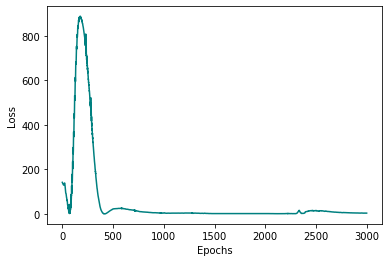

In [3]:
class DINN:
    def __init__(self, t, S_data, I_data, tao_data, T_star_data, u_data): #, t, S_data, I_data, tao_data, T_star_data, u
        self.t = torch.tensor(t, requires_grad=True).float()
        self.S = torch.tensor(S_data)
        self.I = torch.tensor(I_data)
        self.taos = torch.tensor(tao_data)
        self.T_stars = torch.tensor(T_star_data)
        self.u = torch.tensor(u_data, requires_grad=True).float()

        #self.t = t
        #self.S = S_data
        #self.I = I_data
        #self.taos = tao_data
        #self.T_stars = T_star_data
        #self.u_data = u_data

        #learnable parameters
        self.alpha1=torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.alpha2=torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.mu=torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta=torch.nn.Parameter(torch.rand(1, requires_grad=True))

        #NN
        self.nx = self.net_x()
        self.params = list(self.nx.parameters())
        self.params.extend(list([self.alpha1, self.alpha2, self.mu, self.beta]))
        
    #nets
    class net_x(nn.Module): # input = [t, u]
        def __init__(self):
            super(DINN.net_x, self).__init__()
            self.fc1=nn.Linear(1, 200) #takes t
            self.fc2=nn.Linear(200, 200)
            self.out=nn.Linear(200, 2) #outputs S, I

            self.fc11=nn.Linear(1, 200) #takes u
            self.fc22=nn.Linear(200, 200)
            self.outout=nn.Linear(200, 2) #outputs tao, T*

        def forward(self, t, u):
            si=F.relu(self.fc1(t))
            si=F.relu(self.fc2(si))
            si=self.out(si)

            taot=F.relu(self.fc1(u))
            taot=F.relu(self.fc2(taot))
            taot=self.out(taot)
            return si, taot    
    
    
    def net_f(self, t, u):
        #t_u = torch.tensor([t.float(),u.float()], requires_grad = True)

        S, I, tao, T_star = self.nx(t, u) #input = tensor of size 2  
        S_t = grad(S, t, retain_graph=True)[0][0] #derivative of S_pred wrt t              
        I_t = grad(I, t, retain_graph=True)[0][0] #derivative of I_pred wrt t

        f1 = S_t + self.beta * S * I + u * (t > tao) * self.alpha1
        f2 = I_t - self.beta * S * I + self.mu * I + u * (t > tao) * self.alpha2

        return f1, f2
    
        
    def train(self, n_epochs):
        print('\nstarting training...\n')
        losses = []

        learning_rate = 0.001
        optimizer = optim.Adam(self.params, lr = learning_rate)
        
        for epoch in range(n_epochs):
            optimizer.zero_grad()
            print('\nself.alpha1', self.alpha1)            
            for time_step in range(len(self.t)):
                #optimizer.zero_grad()

                t_value, u_value = self.t[time_step], self.u[time_step]
                t_value = torch.tensor(t_value)
                u_value = torch.tensor(u_value)

                f1, f2 = self.net_f(t_value, u_value)
                t_u = torch.tensor([t_value.float(), u_value.float()], requires_grad = True)
                S_pred, I_pred, tao_pred, T_star_pred = self.nx(t_u)
                
                loss = (torch.mean(torch.square(self.S[time_step]-S_pred))+torch.mean(torch.square(self.I[time_step]-I_pred)) \
                    +torch.mean(torch.square(f1)) + torch.mean(torch.square(f2)) \
                    +torch.mean(torch.square(self.taos[time_step]-tao_pred)) + torch.mean(torch.square(self.T_stars[time_step]-T_star_pred)))/100 
                
                loss.backward()
                #torch.nn.utils.clip_grad_norm_(self.nx.parameters(), 500) #gradient clipping
                #optimizer.step()
            optimizer.step()
            losses.append(loss)
            print('loss: ' ,loss)
            print('self.alpha1 after the training!!!: ', self.alpha1)
            
        plt.plot(losses, color = 'teal')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')

dinn = DINN(tSI_data[0], tSI_data[1], tSI_data[2], tao_data[1], tao_data[2], tao_data[3]) #t, S_data, I_data, tao_data, T_star_data, u
dinn.train(3000)